In [2]:
# If using GPU as accelerator
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 10 17:30:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd "/content/drive/My Drive/Colab Notebooks/deep-learning-group"

/content/drive/My Drive/Colab Notebooks/deep-learning-group


In [0]:
import autoreload
%load_ext autoreload

In [0]:
%reload_ext autoreload

In [0]:
import glob
import cv2
import numpy as np
import os


from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler
import csv
import helpers
import pandas as pd
import split_utils
import math

In [8]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/dataset'

batch_size_train = 32
val_size_train = 30
batch_size = 8

colorMode = 'rgb'
classMode = "categorical"
imgSize = 64

base_dir, train_dir, test_dir = split_utils.train_valid_split(DATA_DIR, 0.2, seed=1)

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1, 
                             rescale=1./255,
                             zoom_range=0.3,
                             validation_split=0.25,
                             horizontal_flip=True)

train_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='training')

validation_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='validation')

Found 778 images belonging to 16 classes.
Found 254 images belonging to 16 classes.


**Callback functions list**

In [0]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0.001,
                           patience=20)

**Simple CNN model**

In [0]:
def step_decay(epoch):
  initial_lrate = 0.00025
  drop = 0.8
  epochs_drop = 20
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)

In [0]:
cvsores_1 = []
filepath_1 = "Weights_1.best.hdf5"
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

logpath_1 = "Model_1_history.csv"
log_1 = CSVLogger(logpath_1, append=False)

callback_list_1 = [early_stop, checkpoint_1, log_1, lrate]

def get_compiled_model_1(optimizer='adam', loss='categorical_crossentropy'):
  keras.backend.clear_session()
  # baseModel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))
  baseModel = ResNet50 (include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))

  # Freeze the layers except the last 4 layers
  for layer in baseModel.layers[:-8]:
    layer.trainable = False

  model = Sequential([
                      baseModel,
                      # Conv2D(64, activation='relu', kernel_size=3, input_shape=(imgSize, imgSize, 3)),
                      # BatchNormalization(),
                      # MaxPooling2D(),
                      # Conv2D(64, activation='relu', kernel_size=3),
                      # BatchNormalization(),
                      # MaxPooling2D(),
                      # Conv2D(128, activation='relu', kernel_size=3),
                      # BatchNormalization(),
                      # MaxPooling2D(),
                      # Conv2D(128, activation='relu', kernel_size=3),
                      # BatchNormalization(),
                      AveragePooling2D(),
                      Flatten(),
                      Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
                      Dropout(0.2),
                      Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
                      Dropout(0.2),
                      Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
                      Dropout(0.2),
                      Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
                      Dense(16, activation='softmax')
  ])
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [43]:
#@title Default title text
model_1 = get_compiled_model_1()

history = model_1.fit_generator(train_generator,
                      steps_per_epoch=30,
                      epochs=200,
                      validation_data=validation_generator,
                      validation_steps=20,
                      callbacks=callback_list_1)

Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 10.3169 - accuracy: 0.1562

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


30/30 [==============================] - ETA: 0s - loss: 9.6494 - accuracy: 0.0757
Epoch 00001: val_accuracy improved from -inf to 0.04416, saving model to Weights_1.best.hdf5
30/30 [==============================] - 14s 467ms/step - loss: 9.6494 - accuracy: 0.0757 - val_loss: 8.9170 - val_accuracy: 0.0442 - lr: 2.5000e-04
Epoch 2/200
30/30 [==============================] - ETA: 0s - loss: 8.3185 - accuracy: 0.0800
Epoch 00002: val_accuracy improved from 0.04416 to 0.13407, saving model to Weights_1.best.hdf5
30/30 [==============================] - 14s 462ms/step - loss: 8.3185 - accuracy: 0.0800 - val_loss: 7.7186 - val_accuracy: 0.1341 - lr: 2.5000e-04
Epoch 3/200
30/30 [==============================] - ETA: 0s - loss: 7.2270 - accuracy: 0.1234
Epoch 00003: val_accuracy improved from 0.13407 to 0.16038, saving model to Weights_1.best.hdf5
30/30 [==============================] - 14s 458ms/step - loss: 7.2270 - accuracy: 0.1234 - val_loss: 6.7545 - val_accuracy: 0.1604 - lr: 2.5000

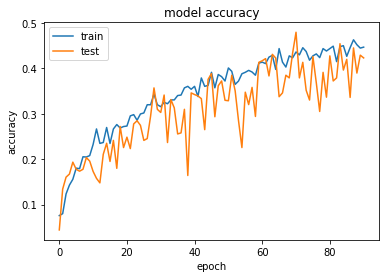

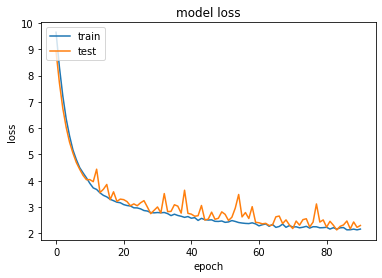

In [44]:
helpers.plotTrainingHistory(history.history)

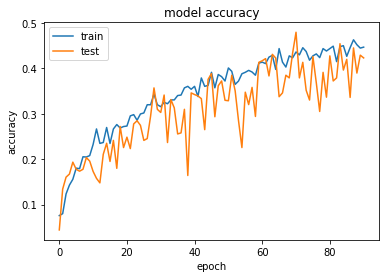

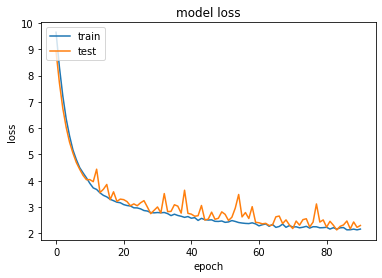

In [45]:
log_data = pd.read_csv(logpath_1)
helpers.plotTrainingHistory(log_data)

In [0]:
del model_1

In [47]:
model_1 = load_model(filepath_1)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [48]:
testgen = ImageDataGenerator(rescale=1./255)

test_generator = testgen.flow_from_directory(test_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size,
                                            shuffle=False)

y_pred = model_1.predict_generator(test_generator, steps = test_generator.samples//batch_size+1, verbose=1)

Found 266 images belonging to 16 classes.
34/34 [==============================] - 2s 56ms/step


In [0]:
le = LabelEncoder()
listLabel = list(test_generator.class_indices.keys())
le.fit(listLabel)
encodedLabel = le.transform(listLabel)

In [0]:
y_pred = np.argmax(y_pred, axis=1)

In [51]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.71      0.53        14
           1       0.45      0.72      0.55        18
           2       0.25      0.20      0.22        15
           3       0.00      0.00      0.00        14
           4       0.44      0.69      0.54        16
           5       0.33      0.07      0.11        15
           6       0.80      0.53      0.64        15
           7       0.88      0.69      0.77        32
           8       0.43      0.50      0.46        18
           9       0.76      0.81      0.79        16
          10       0.50      0.73      0.59        15
          11       0.62      0.67      0.65        15
          12       0.17      0.07      0.10        15
          13       0.48      0.67      0.56        18
          14       0.37      0.47      0.41        15
          15       0.58      0.47      0.52        15

    accuracy                           0.52       266
   macro avg       0.47   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


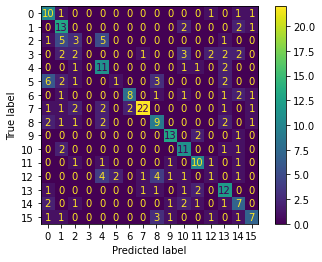

In [52]:
ConfusionMatrixDisplay(confusion_matrix(test_generator.classes, y_pred), encodedLabel).plot()

**Simple model using transfer learning**

In [0]:
cvscores_2 = []
def get_compiled_model_2():
  keras.backend.clear_seesion()
  baseModel = VGG16(weights='imagenet',
                    include_top=False,
                    input_tensor=Input(shape=(imgSize, imgSize, 3)))
  
  for layer in baseModel.layers[:-5]:
    layer.trainable = False
  
  

In [54]:
test_generator.class_indices

{'adho mukha svanasana': 0,
 'ardha matsyendrasana': 1,
 'astavakrasana': 2,
 'baddha konasana': 3,
 'bakasana': 4,
 'balasana': 5,
 'bhujangasana': 6,
 'bitilasana': 7,
 'chaturanga dandasana': 8,
 'garudasana': 9,
 'gomukhasana': 10,
 'natarajasana': 11,
 'supta baddha konasana': 12,
 'ustrasana': 13,
 'utkatasana': 14,
 'vasisthasana': 15}

**Results Summary**